# <a>CaPtcHA</a>

<img src='data/img/logo.gif' width=600>

___
## <center><a id=0 style='color:red'>Импорт библиотек</a>

In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from pytorch_lightning import seed_everything
import torch
from torchvision import transforms
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch import nn
from torchsummary import summary
from torch import optim
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time
import pandas as pd
from IPython import display
from tqdm import trange

___
## <center><a id=1 style='color:red'>Предобработка данных</a>

### <a id=2>Data import</a>

In [3]:
DATADIR_PATH = 'data'
IMAGE_FILE = 'images.npy'
LABEL_FILE = 'labels.npy'
TESTIMAGE_FILE = 'images_sub.npy'

img_data = np.load(os.path.join(DATADIR_PATH, IMAGE_FILE))
label_data = np.load(os.path.join(DATADIR_PATH, LABEL_FILE))
testimg_data = np.load(os.path.join(DATADIR_PATH, TESTIMAGE_FILE))

img_data.shape, label_data.shape, testimg_data.shape

((20000, 48, 48, 3), (20000,), (50000, 48, 48, 3))

### <a id=4>train-val split </a>

In [4]:
seed_everything(42)
X_train, X_val, y_train, y_val = train_test_split(img_data, label_data, test_size=0.1)

X_train.shape, y_train.shape, X_val.shape,  y_val.shape

Seed set to 42


((18000, 48, 48, 3), (18000,), (2000, 48, 48, 3), (2000,))

### <a id=2>array -> tensor </a>

In [5]:
train_img_tensor = torch.FloatTensor(X_train).permute(0, 3, 1, 2)
train_label_tensor = torch.LongTensor(y_train)

val_img_tensor = torch.FloatTensor(X_val).permute(0, 3, 1, 2)
val_label_tensor = torch.LongTensor(y_val)

test_img_tensor = torch.FloatTensor(testimg_data).permute(0, 3, 1, 2)

train_img_tensor.shape, train_label_tensor.shape, val_img_tensor.shape,  val_label_tensor.shape, test_img_tensor.shape, 

(torch.Size([18000, 3, 48, 48]),
 torch.Size([18000]),
 torch.Size([2000, 3, 48, 48]),
 torch.Size([2000]),
 torch.Size([50000, 3, 48, 48]))

### <a id=8>Augmentation</a>

In [6]:
train_augmentation = transforms.Compose([
                                        transforms.Normalize([127], [0.2]),
                                        ])

val_augmentation = transforms.Compose([
                                        transforms.Normalize([127], [0.2]),
                                        ])

train_img_aug = train_augmentation(train_img_tensor)
val_img_aug = val_augmentation(val_img_tensor)
test_img_aug = val_augmentation(test_img_tensor)

train_img_aug.shape, val_img_aug.shape, test_img_aug.shape

(torch.Size([18000, 3, 48, 48]),
 torch.Size([2000, 3, 48, 48]),
 torch.Size([50000, 3, 48, 48]))

### <a id=3>tensor -> TensorDataset </a>

In [7]:
train_dataset_aug = Data.TensorDataset(train_img_aug, train_label_tensor)
train_dataset = Data.TensorDataset(train_img_tensor, train_label_tensor)
val_dataset = Data.TensorDataset(val_img_tensor, val_label_tensor)
val_dataset_aug = Data.TensorDataset(val_img_aug, val_label_tensor)

print(f'Train dataset (tensor, label): ,({next(iter(train_dataset_aug))[0].shape}, {next(iter(train_dataset_aug))[1]})')

Train dataset (tensor, label): ,(torch.Size([3, 48, 48]), 16)


### <a id=5>TensorDataset -> DataLoader </a>

In [8]:
BATCH_SIZE = 50

train_loader_aug = Data.DataLoader(train_dataset_aug,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                )

train_loader = Data.DataLoader(train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                )

val_loader = Data.DataLoader(val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                )

val_loader_aug = Data.DataLoader(val_dataset_aug,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                )

test_loader = Data.DataLoader(testimg_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

test_loader_aug = Data.DataLoader(test_img_aug,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

next(iter(train_loader_aug))[0].shape, next(iter(test_loader)).shape

(torch.Size([50, 3, 48, 48]), torch.Size([50, 48, 48, 3]))

### <a id=6>Data visuialize </a>

До аугментации: 


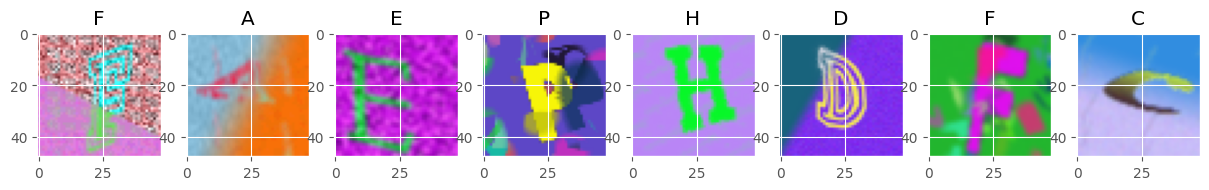

In [9]:
def plot_data(loader: Data.DataLoader, img_num=8)->None:
    plt.style.use('ggplot')

    x, y = next(iter(loader))
    x = x[:img_num]
    y = y[:img_num]
    fig, ax = plt.subplots(1, img_num, figsize=(15,8))
    for i in range(img_num):
        img_arr = x[i,:,:].permute(1,2,0).type(torch.int32)
        tgt = y[i].reshape(-1).cpu().item()
        ax[i].imshow(img_arr.cpu())
        ax[i].set_title(f'{chr(tgt + 65)}')

print('До аугментации: ')
plot_data(loader=train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


После аугментации: 


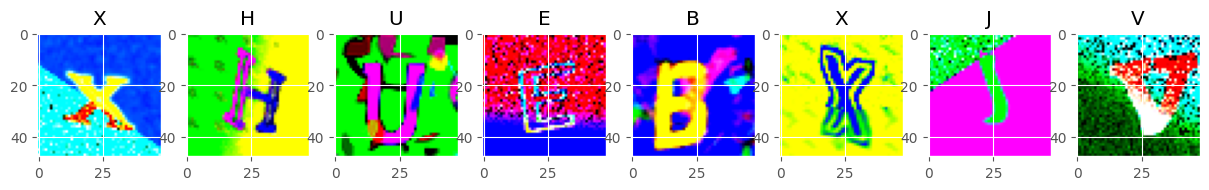

In [15]:
print('После аугментации: ')
plot_data(loader=train_loader_aug)

___
## <center><a id=9 style='color:red'>Модель</a>

### <a id=10> Model architecture</a>

In [16]:
class CaptchaNN(nn.Module):
    def __init__(self):
        super(CaptchaNN, self).__init__()

        IN_CHANNEL = 122
        
        self.ConvIn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=78, kernel_size=3, padding=1),
            nn.BatchNorm2d(78),
            nn.RReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.RReLU(),
            nn.Conv2d(in_channels=78, out_channels=96, kernel_size=1, padding=0),
            nn.BatchNorm2d(96),
            nn.RReLU(),
            nn.Conv2d(in_channels=96, out_channels=IN_CHANNEL, kernel_size=3, padding=1),
            nn.BatchNorm2d(IN_CHANNEL),
            nn.RReLU(),
            nn.Dropout(p=0.4)
            )

        self.Incept1 = InceptionBlock(IN_CHANNEL,
                                    int(IN_CHANNEL*0.75), 
                                    int(IN_CHANNEL*0.75), int(IN_CHANNEL*0.25), 
                                    int(IN_CHANNEL*0.75), int(IN_CHANNEL*0.50), int(IN_CHANNEL*0.25))
        IN_CHANNEL = 151
        self.Incept2 = InceptionBlock(IN_CHANNEL, 
                                    int(IN_CHANNEL*0.75), 
                                    int(IN_CHANNEL*0.75), int(IN_CHANNEL*0.25), 
                                    int(IN_CHANNEL*0.75), int(IN_CHANNEL*0.50), int(IN_CHANNEL*0.25))

        
        self.ConvOut = nn.Sequential(
            nn.Conv2d(in_channels=187, out_channels=156, kernel_size=3, padding=0),
            nn.RReLU(),
            nn.BatchNorm2d(156),
            nn.Conv2d(in_channels=156, out_channels=182, kernel_size=3, padding=0),
            nn.RReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(182),
            nn.Dropout2d(p=0.6)
            )

        self.LinearOut = nn.Sequential(
            nn.Linear(in_features=1 * 1 * 182, out_features=26),
            nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        
        x = self.ConvIn(x)
        
        x = self.Incept1(x)
        x = self.Incept2(x)
        
        x = self.ConvOut(x)

        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        
        x= self.LinearOut(x)
        
        return x


class InceptionBlock(nn.Module):
    def __init__(self,
                x_in=122,
                cb_1=78,
                cb_2_1=64,
                cb_2_2=42,
                cb_3_1=64, 
                cb_3_2=42,
                cb_3_3=26):
        super(InceptionBlock, self).__init__()

        self.Conv1 = nn.Sequential(
            nn.Conv2d(in_channels=x_in, out_channels=cb_1, kernel_size=1, padding=0, stride=1),
            nn.RReLU(),
            nn.BatchNorm2d(cb_1)
            
            )
        self.Conv2 = nn.Sequential(
            nn.Conv2d(in_channels=x_in, out_channels=cb_2_1, kernel_size=1, padding=0, stride=1),
            nn.RReLU(),
            nn.Conv2d(in_channels=cb_2_1, out_channels=cb_2_2, kernel_size=3, padding=1, stride=1),
            nn.RReLU(),
            nn.BatchNorm2d(cb_2_2)
            
            )
        self.Conv3 = nn.Sequential(
            nn.Conv2d(in_channels=x_in, out_channels=cb_3_1, kernel_size=1, padding=0, stride=1),
            nn.RReLU(),
            nn.Conv2d(in_channels=cb_3_1, out_channels=cb_3_2, kernel_size=3, padding=1, stride=1),
            nn.RReLU(),
            nn.Conv2d(in_channels=cb_3_2, out_channels=cb_3_3, kernel_size=3, padding=1, stride=1),
            nn.RReLU(),
            nn.BatchNorm2d(cb_3_3)
            
            )
        
        self.do = nn.Dropout2d(p=0.4)
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(cb_1 + cb_2_2 + cb_3_3)
    def forward(self, x):

        x1 = self.Conv1(x)
        x2 = self.Conv2(x)
        x3 = self.Conv3(x)
        x = torch.cat( [ x1, x2, x3], 1)
        
        x = self.mp(x)
        x = self.bn(x)
        x= self.do(x)
        
        return x


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = CaptchaNN().to(device=device)
summary(model=model, input_size=(3,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 78, 48, 48]           2,184
       BatchNorm2d-2           [-1, 78, 48, 48]             156
             RReLU-3           [-1, 78, 48, 48]               0
         MaxPool2d-4           [-1, 78, 24, 24]               0
             RReLU-5           [-1, 78, 24, 24]               0
            Conv2d-6           [-1, 96, 24, 24]           7,584
       BatchNorm2d-7           [-1, 96, 24, 24]             192
             RReLU-8           [-1, 96, 24, 24]               0
            Conv2d-9          [-1, 122, 24, 24]         105,530
      BatchNorm2d-10          [-1, 122, 24, 24]             244
            RReLU-11          [-1, 122, 24, 24]               0
          Dropout-12          [-1, 122, 24, 24]               0
           Conv2d-13           [-1, 91, 24, 24]          11,193
            RReLU-14           [-1, 91,

### <a id=11> Model training</a>

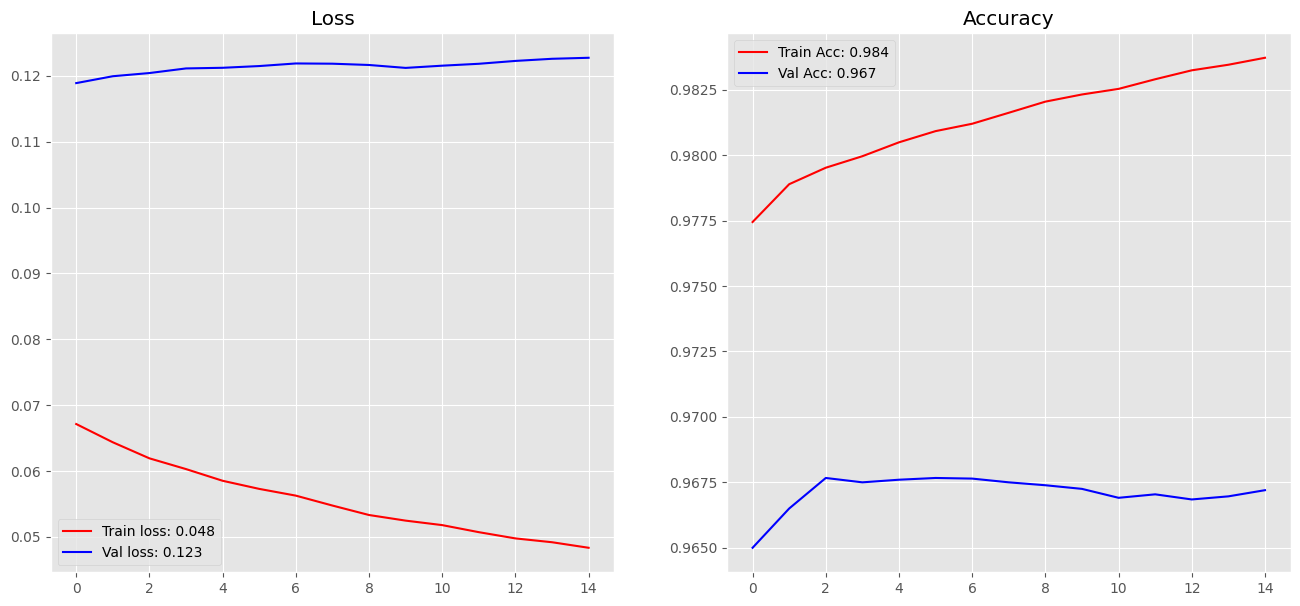

<Figure size 1500x700 with 0 Axes>

  2%|▎         | 15/600 [03:54<2:53:44, 17.82s/it]

In [32]:
def train_model(model,
                device,
                loss,
                optimizer,
                scheduler=None,
                num_epochs=10,
                train_loader=train_loader_aug,
                val_loader=val_loader_aug):

    train_loss_history, val_loss_history , train_acc_history, val_acc_history = [], [],[], []
    epoch_loss_train, epoch_acc_train, epoch_loss_val, epoch_acc_val = [], [],[], []
    
######## Итерации по эпохам ###################################
    for epoch in trange(num_epochs):

######## Итерации по батчам ###################################

        for data in train_loader:
            x_batch, y_batch = data
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

######## Прямой - Обратный проход #############################

            model.train()
            optimizer.zero_grad()
            preds = model(x_batch)
            loss_value = loss(preds, y_batch)
            preds_class = preds.argmax(dim=1)
            loss_value.backward()
            optimizer.step()
            scheduler.step(loss_value)

######## Метрики качества при обучении ########################

            batch_loss_train = loss(preds, y_batch).data.cpu()
            batch_acc_train = ( preds_class == y_batch).float().mean().data.cpu()
            train_loss_history.append( batch_loss_train )
            train_acc_history.append(batch_acc_train.cpu() )
        epoch_loss_train.append(np.array(train_loss_history).mean())
        epoch_acc_train.append(np.array(train_acc_history).mean())

######## Метрики качества при валидации #######################

        for data in val_loader:
            x_batch, y_batch = data
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            model.eval()
            with torch.no_grad():
                val_preds = model.forward(x_batch)
                batch_loss_val = loss(val_preds, y_batch).data.cpu()
                batch_acc_val = (val_preds.argmax(dim=1) == y_batch).float().mean().data.cpu()
                val_loss_history.append( batch_loss_val )
                val_acc_history.append(batch_acc_val.cpu() )
        epoch_loss_val.append(np.array(val_loss_history).mean())
        epoch_acc_val.append(np.array(val_acc_history).mean())

######## Отрисовка средних метрик по эпохам ###################

        plt.style.use('ggplot');
        fig, ax = plt.subplots(1, 2, figsize=(16,7))
        display.clear_output(True)
        plt.figure(figsize=(15,7))
        ax[0].plot(epoch_loss_train, label=f'Train loss: {epoch_loss_train[-1]:.3f}', c='r')
        ax[0].plot(epoch_loss_val, label=f'Val loss: {epoch_loss_val[-1]:.3f}', c='b')
        ax[1].plot(epoch_acc_train, label=f'Train Acc: {epoch_acc_train[-1]:.3f}', c='r')
        ax[1].plot(epoch_acc_val, label=f'Val Acc: {epoch_acc_val[-1]:.3f}', c='b');
        ax[0].legend()
        ax[1].legend();
        ax[0].set_title('Loss')
        ax[1].set_title('Accuracy');
        plt.show();
        
        torch.save(model, f'data/models/model_tmp.pkl')
    return model


optimizer = optim.Adam( model.parameters(), lr=0.003)
loss_func = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=3, factor=0.1, cooldown=198000)

trained_model = train_model(model=model,
            device=device,
            loss=loss_func,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=600,
            );

### <a id=13>Model evaluation</a>

Accuracy score: 0.9675
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        80
           1       0.94      0.95      0.95        85
           2       0.97      0.97      0.97        67
           3       0.93      0.99      0.96        85
           4       0.99      0.94      0.96        84
           5       0.92      0.99      0.95        67
           6       0.93      0.98      0.95        81
           7       0.96      0.99      0.97        79
           8       0.93      0.88      0.90        43
           9       0.93      0.92      0.92        59
          10       1.00      0.98      0.99        84
          11       0.98      1.00      0.99        42
          12       0.98      0.98      0.98        98
          13       1.00      0.97      0.98        87
          14       0.96      0.93      0.95        87
          15       1.00      0.95      0.98        83
          16       0.95      0.94 

<Axes: >

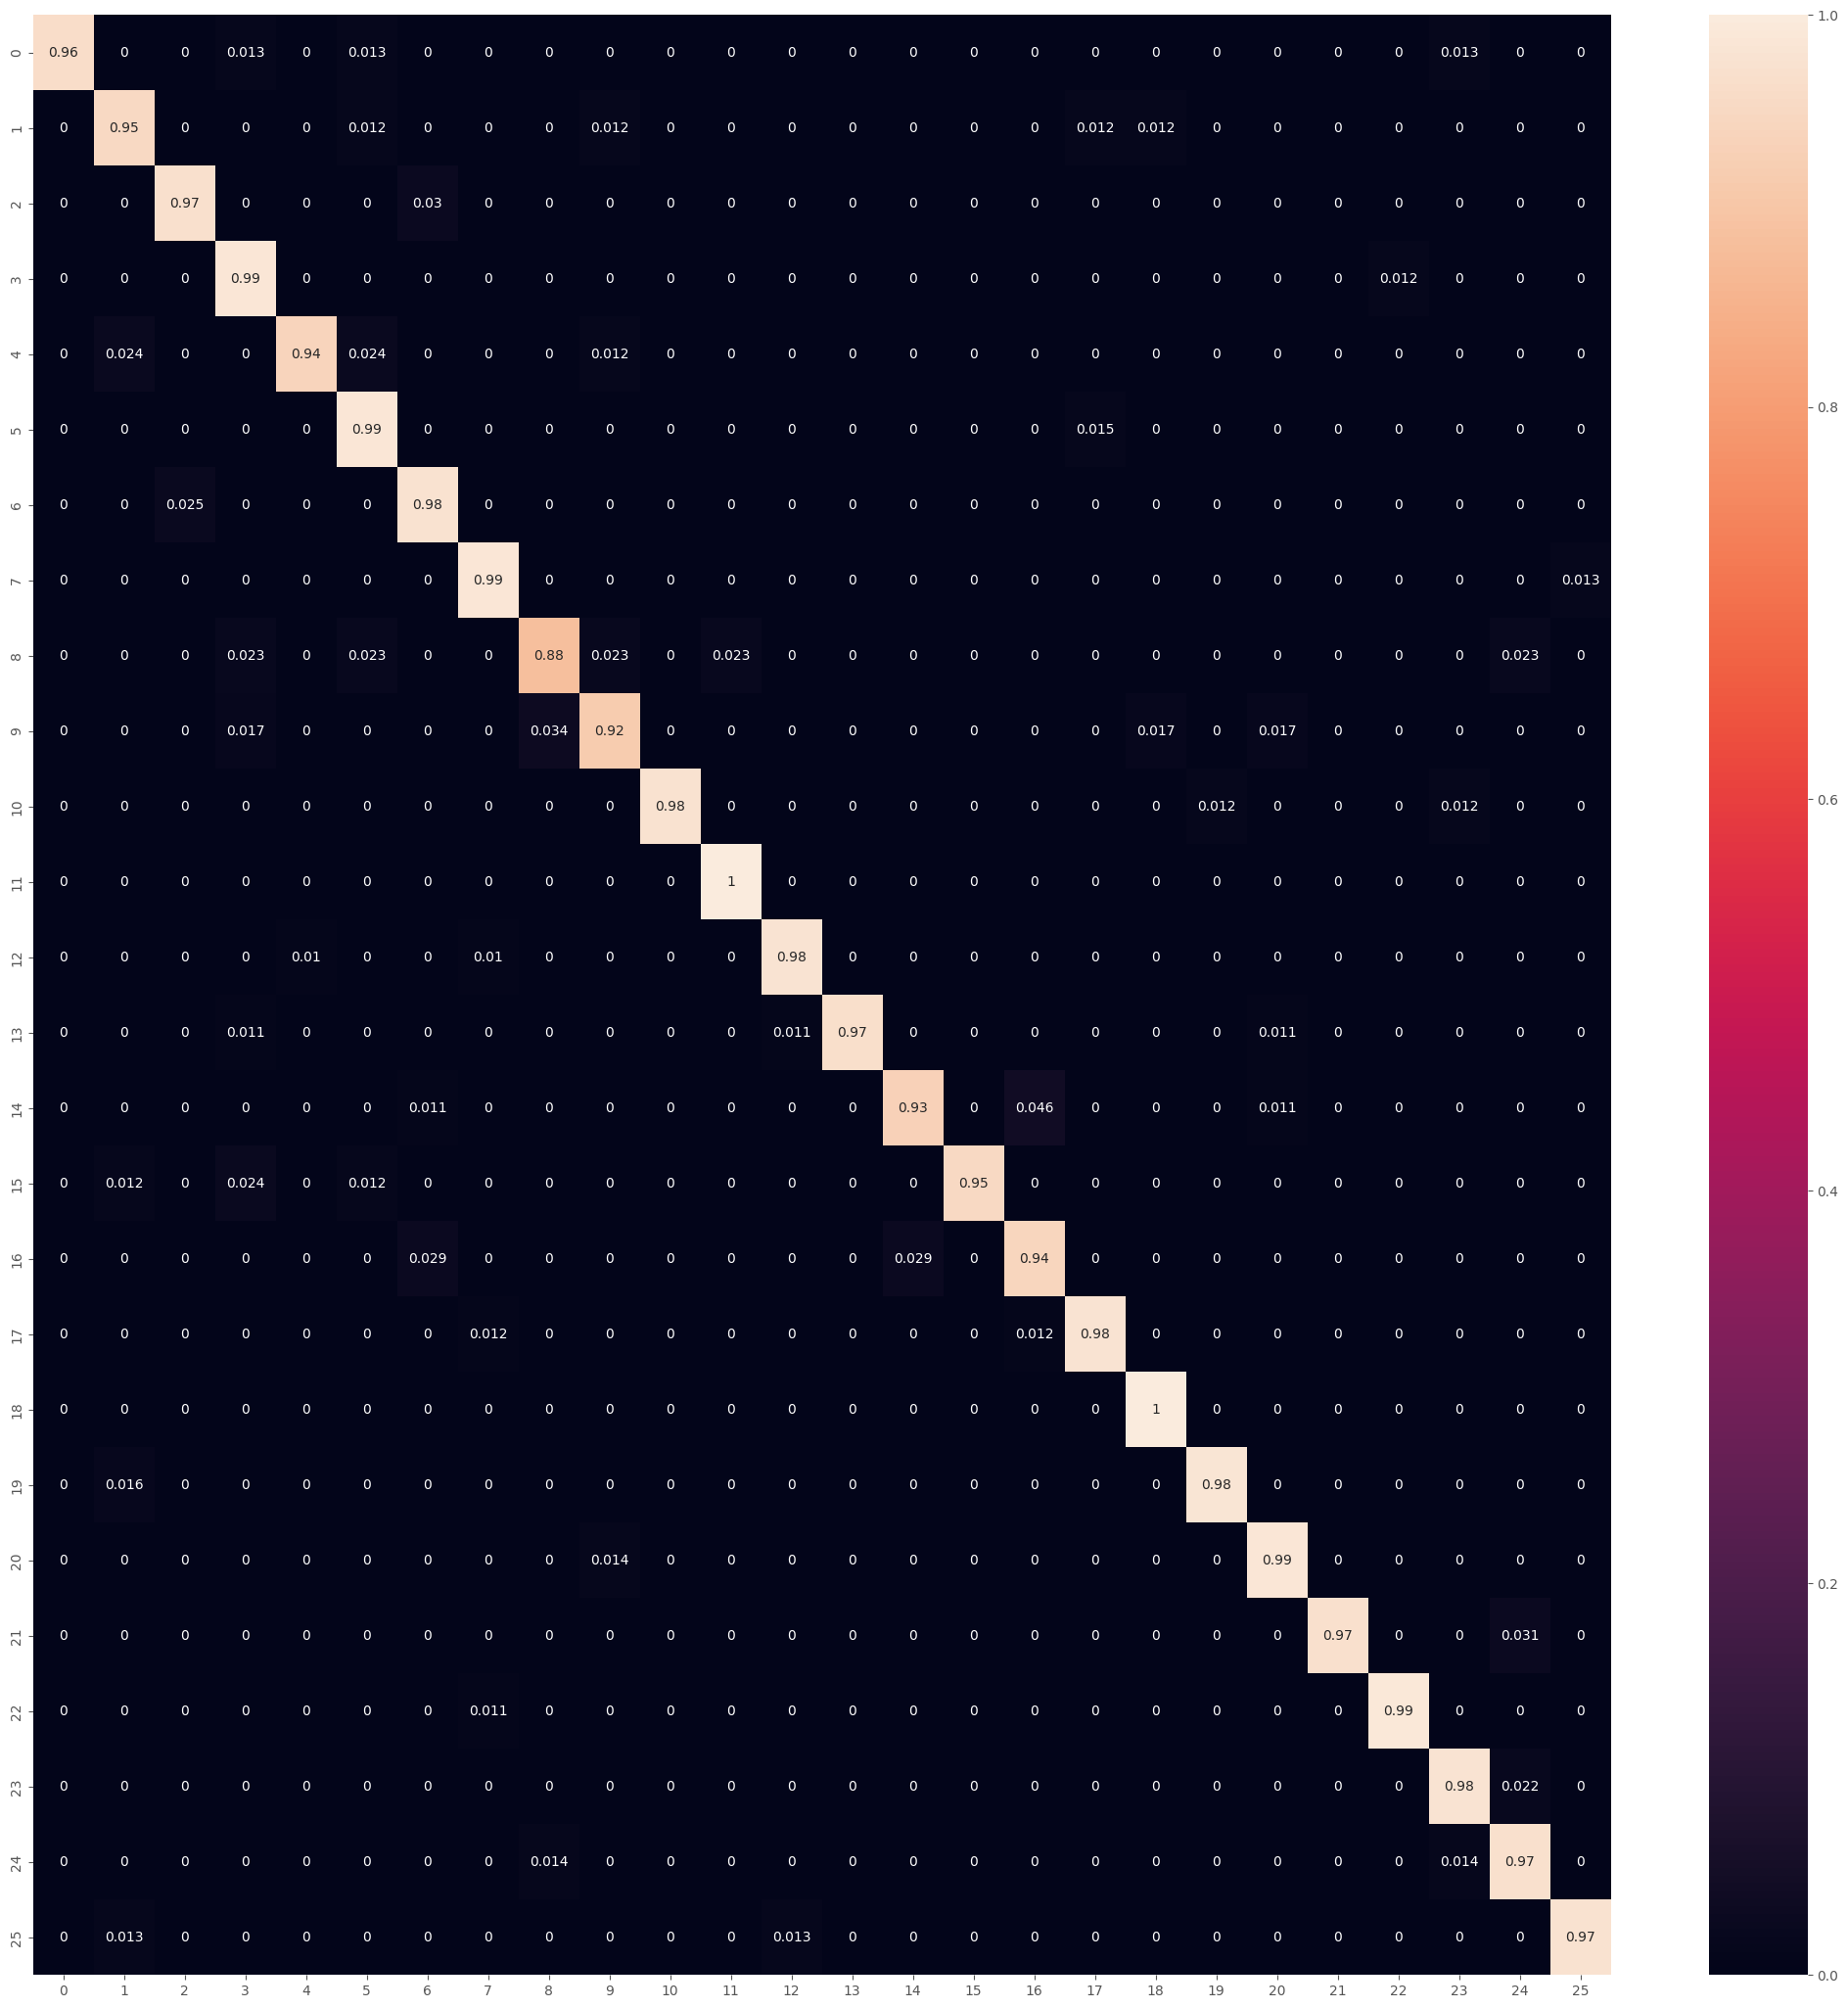

In [31]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in val_loader_aug:
        y_predicted = model(batch[0].to(device))
        predicted_labels.append(y_predicted.argmax(dim=1).cpu())
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
accuracy = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

report = classification_report(real_labels,  predicted_labels.cpu())
print(f'Accuracy score: {accuracy:.4f}')
print("Classification report:\n", report)
matrix = confusion_matrix(real_labels, predicted_labels, normalize='true')
plt.figure(figsize=(26,26))
sns.heatmap(matrix, annot=True, fmt='.2g')


___
## <center><a id=16 style='color:red'>Запись результатов</a>

### Test predict

In [25]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader_aug:
        y_predicted = model(batch.to(device))
        predicted_labels.append(y_predicted.argmax(dim=1).cpu())


predicted_labels = torch.cat(predicted_labels)
predicted_labels

tensor([19,  8, 14,  ..., 14,  3, 25])

### Prediction -> CSV

In [26]:
def record_submition(sample_path: str = 'data/submitions/sample_submission.csv',
                   submition_path: str='data/submitions',
                   submition_column: str='Category',
                   model_result: torch.Tensor=predicted_labels,
                   accuracy_value: int=accuracy) -> None:
    """Запись результата предсказания модели в csv-файл

    Args:
        sample_path (str, optional): Путь к csv-примеру. Defaults to 'data/sample_submission.csv'.
        submition_path (str, optional): Путь к папке с результатами (csv). Defaults to 'data/submitions'.
        submition_column (str, optional): Столбец, в котором находится таргет. Defaults to 'Category'.
        model_result (torch.Tensor, optional): Результат предсказания модели. Defaults to pred_classes.
        accuracy_value (int, optional): Точность предсказания. Defaults to accuracy.
    """
    df_sample = pd.read_csv(sample_path, index_col=False)
    df_result = df_sample.copy()

    df_result[submition_column] = model_result.cpu().data
    date = time.ctime().replace(' ', '_').replace(':', '_')[:-8]

    file_name = f'Captcha_{date}_{accuracy_value:.3f}.csv'
    result_path = os.path.join(submition_path, file_name)
    df_result.to_csv(result_path, index=False)
    torch.save(model, f'data/models/model_{accuracy_value:.3f}.pkl')
    print(f'{file_name} recorded!')

record_submition()

Captcha_Tue_May__7_13_44_0.974.csv recorded!
